# UNet trained with baseline data + TorchIO augmented data

## Qimin Zhang and Weiwei Qi

# *0427 Revisit: use binary mask*

## 1. Config

In [2]:
import os
import copy
import enum
from time import time
import random
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from unet import U_Net

from glob import glob
import pickle
warnings.filterwarnings('ignore')

import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM

from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import nibabel as nib
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm import tqdm

print('TorchIO version:', torchio.__version__)

training_split_ratio = 0.9
num_epochs = 5
compute_histograms = False
train_whole_images = False
train_patches = False

from torchio.transforms import (
    RandomFlip, # check axis
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise, # lower noise
    RandomMotion, # no use
    RandomBiasField,
    RandomSpike,
    RandomBlur,
    Rescale,
    Resample,
    ToCanonical,
    ZNormalization,
    CenterCropOrPad,
    HistogramStandardization,
    Interpolation,
    RandomGhosting
)

seed = 4460
torch.manual_seed(4460)
np.random.seed(4460)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696

TorchIO version: 0.15.5


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

Computation Details
	Device Used: (cuda)  Tesla K80

Packages Used Versions:-
	Pytorch Version: 1.4.0


## 2. Train a U-Net with original data + TorchIO augmented data

In [4]:
# Dataset folder used
DATASET_PATH = os.path.join('./data')

# We would like to perform a train-validation-test split at the ratio of T:V:T = 8:1:1.
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Training Epochs
epochs = 80

In [5]:
print(sorted(glob("./data/all_gbm_pre_reg/*_t1reg.nii.gz"))[0])
print(sorted(glob("./data/all_tumors_reg/*_seg_reg.nii.gz"))[0])

./data/all_gbm_pre_reg/BraTS19_2013_0_1_t1reg.nii.gz
./data/all_tumors_reg/BraTS19_2013_0_1_seg_reg.nii.gz


In [6]:
class TumorDataset(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale()
        ])
        self.DEBUG = DEBUG
            

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg")
        
        image_name = sorted(glob(os.path.join(image_path, "*t1reg.nii.gz")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*seg_reg.nii.gz")))[index]

        # Use nibabel to open the images and masks.
        image = nib.load(image_name).get_fdata()
        mask = nib.load(mask_name).get_fdata()
        mask = (mask > 0)

        # Apply the default transformations on the images and masks.
        #image = self.default_transformation(image)
        #mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': index, 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg', '*t1reg.nii.gz')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg', '*seg_reg.nii.gz')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files

In [7]:
class TumorDataset_Aug(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale()
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg")
        
        image_name = sorted(glob(os.path.join(image_path, "*t1reg.nii.gz")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*seg_reg.nii.gz")))[index]

        # Use nibabel to open the images and masks.
        image = nib.load(image_name)
        mask = nib.load(mask_name)

        # Apply the default transformations on the images and masks.
        #image = self.default_transformation(image)
        #mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        #image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask)
        
#        transfrom_randint = np.random.choice(2,1,p=[0.5,0.5]).item()
        
#         if transfrom_randint == 0:
            
#             image = image.get_fdata()
#             mask = mask.get_fdata()
            
#             image = torch.tensor(image).type('torch.DoubleTensor')
#             mask = torch.tensor(mask).type('torch.DoubleTensor')
            
#             sample = {'index': index, 'image': image, 'mask': mask}
        
#        elif transfrom_randint == 1:
            
        # no transform, RandomAffine, RandomElasticDeformation, RandomFlip
        spatial_augmentation_type = np.random.choice(4,1, p = [0.1, 0.4, 0.25, 0.25]).item()
        # no transform, RandomNoise, RandomBiasField, RandomMotion, RandomGhosting
        # For now only introduce random Gaussian noise
        intensity_augmentation_type = np.random.choice(4,1, p = [0.05, 0.48, 0.36, 0.11]).item()

        if spatial_augmentation_type == 1:
            spatial_transform = RandomAffine(scales=(0.9,1.1),degrees=(-6,6),
                                            image_interpolation=Interpolation.NEAREST,seed=seed)
        elif spatial_augmentation_type == 2:
            spatial_transform = RandomElasticDeformation(num_control_points=20,locked_borders=2,
                                                        proportion_to_augment=1, 
                                                        image_interpolation=Interpolation.NEAREST,
                                                        seed=seed) 
                                                         #deformation_std = 50)
        elif spatial_augmentation_type == 3:
            axis = np.random.choice([0,2],1).item()
            spatial_transform = RandomFlip(seed = seed, flip_probability = 1, axes = axis)

        if intensity_augmentation_type == 1: 
            intensity_transform = RandomNoise(seed = seed, std = (0, 5))
        elif intensity_augmentation_type == 2: 
            intensity_transform = RandomBlur(std=(0, 0.5),seed=seed)
        elif intensity_augmentation_type == 3:
            intensity_transform = RandomGhosting(seed = seed, 
                                                 proportion_to_augment = 1, 
                                                 num_ghosts = (1, 3))

        subject = {
            'image': {DATA: torch.from_numpy(image.get_fdata().astype(np.float32)).unsqueeze(0), AFFINE: image.affine, TYPE: torchio.INTENSITY},
            'mask': {DATA: torch.from_numpy((mask.get_fdata() > 0).astype(np.float32)).unsqueeze(0), AFFINE: mask.affine, TYPE: torchio.LABEL}
            }

        # Apply spatial transform. 
        # spatial_transformed_subject = spatial_transform(subject) if spatial_augmentation_type > 0 else subject
        transformed_subject = spatial_transform(subject) if spatial_augmentation_type > 0 else subject
        transformed_subject = intensity_transform(transformed_subject) if intensity_augmentation_type > 0 else transformed_subject

        image = np.squeeze(transformed_subject['image']['data'].numpy())
        mask = np.squeeze(transformed_subject['mask']['data'].numpy())

        image = torch.tensor(image).type('torch.DoubleTensor').permute(2, 0, 1)
        mask = torch.tensor(mask).type('torch.DoubleTensor').permute(2, 0, 1)

        sample = {'index': index, 'image': image, 'mask': mask}

        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg', '*t1reg.nii.gz')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg', '*seg_reg.nii.gz')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files

In [8]:
def get_indices(length, val_split, test_split):
    '''
    Gets the Training & Testing data indices for the dataset.
    Stores the indices and returns them back when the same dataset is used.
    Inputs:
        length(int): Length of the dataset used.
        val_split: the portion (0 to 1) of data used for validation.
        test_split: the portion (0 to 1) of data used for testing.
    Parameters:
        train_indices(list): Array of indices used for training purpose.
        validation_indices(list): Array of indices used for validation purpose.
        test_indices(list): Array of indices used for testing purpose.
    '''
    data = dict()
    indices = list(range(length))
    np.random.shuffle(indices)
    split1 = int(np.floor(test_split * len(tumor_dataset)))
    split2 = split1 + int(np.floor(val_split * len(tumor_dataset)))
    train_indices, validation_indices, test_indices = indices[split2:], indices[split1:split2], indices[:split1]
    return train_indices, validation_indices, test_indices

In [9]:
def dice_coefficient(predicted, target):
    '''
    Calculates the Sørensen–Dice Coefficient for a single sample.
    Parameters:
        predicted(numpy.ndarray): Predicted single output of the network.
                                Shape - (Channel, Height, Width)
        target(numpy.ndarray): Actual required single output for the network
                                Shape - (Channel, Height, Width)

    Returns:
        coefficient(float): Dice coefficient for the input sample.
                                    1 represents highest similarity and
                                    0 represents lowest similarity.
    '''
    # The smooth term is used to prevent division by zero.
    smooth = 1
    product = np.multiply(predicted, target)
    intersection = np.sum(product)
    coefficient = (2 * intersection + smooth) / (np.sum(predicted) + np.sum(target) + smooth)
    return coefficient

In [10]:
tumor_dataset = TumorDataset(DATASET_PATH)
tumor_dataset_aug = TumorDataset_Aug(DATASET_PATH)


train_indices, validation_indices, test_indices = get_indices(len(tumor_dataset), val_split = VAL_SPLIT, test_split = TEST_SPLIT)
train_sampler, validation_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler = train_sampler)
trainloader_aug = torch.utils.data.DataLoader(tumor_dataset_aug, BATCH_SIZE, sampler = train_sampler)
validationloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = validation_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = test_sampler)

print('Number of files in the train set: %s \nNumber of files in the validation set: %s \nNumber of files in the test set: %s' \
      % (len(train_indices), len(validation_indices), len(test_indices)))

Number of files in the train set: 269 
Number of files in the validation set: 33 
Number of files in the test set: 33


In [11]:
# Run to save TorchIO augmented data. Don't run.

# os.makedirs('./data/all_gbm_pre_reg_train_torchio_aug/', exist_ok = True)
# os.makedirs('./data/all_tumors_reg_train_torchio_aug/', exist_ok = True)

# trainloader_aug = torch.utils.data.DataLoader(tumor_dataset_aug, 1, sampler = train_sampler)
# index = 0
# for batch, data in enumerate(trainloader_aug):
#     image = data['image'].view([155,240,240])
#     mask = data['mask'].view([155,240,240])
#     torch.save(image, './data/all_gbm_pre_reg_train_torchio_aug/'+str(index)+'.pt')
#     torch.save(mask, './data/all_tumors_reg_train_torchio_aug/'+str(index)+'.pt')
#     index += 1

In [12]:
class TumorDataset_Aug(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale()
        ])
        self.DEBUG = DEBUG
            

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg_train_torchio_aug")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg_train_torchio_aug")
        
        image_name = sorted(glob(os.path.join(image_path, "*.pt")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*.pt")))[index]

        # Use nibabel to open the images and masks.
        image = torch.load(image_name)
        mask = torch.load(mask_name)

        # Apply the default transformations on the images and masks.
        #image = self.default_transformation(image)
        #mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        #image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask)
        
        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': index, 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg_train_torchio_aug', '*.pt')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg_train_torchio_aug', '*.pt')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files

In [13]:
tumor_dataset_aug = TumorDataset_Aug(DATASET_PATH)
trainloader_aug = torch.utils.data.DataLoader(tumor_dataset_aug, BATCH_SIZE)

In [14]:
import torchio
from torchio.transforms import Rescale, RandomAffine
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

In [15]:
# Some visualization functions

def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_sample(sample, image_name, label_name=None):
    if label_name is not None:
        sample = copy.deepcopy(sample)
        affine = sample[label_name][AFFINE]
        label = sample[label_name][DATA][0].numpy().astype(np.uint8)
        label_image = torchio.utils.nib_to_sitk(label, affine)
        border = sitk.BinaryContour(label_image)
        border_array, _ = torchio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)
        image_tensor = sample[image_name][DATA][0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        torchio.ImagesDataset.save_sample(sample, {image_name: f.name})
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [16]:
dataPath = Path('./data')

t1_path = dataPath / 'all_gbm_pre_reg'
tumor_path = dataPath / 'all_tumors_reg'

t1_locations = sorted(t1_path.glob('*.nii.gz'))
tumor_locations = sorted(tumor_path.glob('*.nii.gz'))


assert len(t1_locations) == len(tumor_locations)

subjects = []
for (image_path, label_path) in zip(t1_locations, tumor_locations):
    subject = torchio.Subject(
        {'image': torchio.Image(image_path, torchio.INTENSITY),
        'mask': torchio.Image(label_path, torchio.LABEL)}
    )
    subjects.append(subject)
    
dataset = torchio.ImagesDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 335 subjects


### 3.1 Exploration

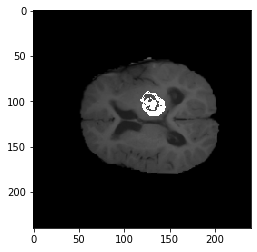

In [17]:
sample = dataset[0]
show_sample(sample, 'image', label_name='mask')

### 2.2 Augmentation

#### 2.2.1 Intensity

#### 2.2.2 Spatial

#### 2.2.3 Train a network

--------------------**if you have already trained the network offline, skip the blow three chunk**---------------------

In [16]:
unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&torchio_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
# Use when you want to continue training a pre-train model.
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model_0428_0.82.pth'))
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)

<All keys matched successfully>

In [17]:
print(tumor_dataset.__getitem__(0)['image'].size())
print(tumor_dataset_aug.__getitem__(0)['image'].size())

torch.Size([155, 240, 240])
torch.Size([155, 240, 240])


In [18]:
# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    train_score, validation_score, validation_loss = 0, 0, 0
            
#     for batch, data in enumerate(trainloader):
#         # Keeping track how many iteration is happening.
#         batch_iteration += 1
#         # Loading data to device used.
#         image = data['image'].to(device, dtype=torch.float)
#         mask = data['mask'].to(device, dtype=torch.float)
        
#         #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         # Clearing gradients of optimizer.
#         optimizer.zero_grad()
#         # Calculation predicted output using forward pass.
#         output = unet_model(image)
#         # Calculating the loss value.
#         loss_value = criterion(output, mask)
#         # Computing the gradients.
#         loss_value.backward()
#         # Optimizing the network parameters.
#         optimizer.step()
#         # Updating the running training loss
#         train_epoch_loss += loss_value.item()
#         train_batch_loss += loss_value.item()
        
#         mask_prediction = unet_model(image)
#         mask_prediction = (mask_prediction > 0.5)
#         mask_prediction = mask_prediction.cpu().numpy()
#         mask_prediction = np.resize(mask_prediction, (155, 240, 240))
#         mask = mask.cpu().numpy()
#         # Calculate the dice score for original and predicted image mask.
#         train_score += dice_coefficient(mask_prediction, mask)
    

#         # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
#         if mini_batch:
#             if (batch + 1) % mini_batch == 0:
#                 train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
#                 print(
#                     f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
#                 train_batch_loss = 0
    
    for batch, data in enumerate(trainloader_aug):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
    unet_train = train_score / batch_iteration
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'train score: {unet_train:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'torchio_rand_aug_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.00653,  train score: 0.11157,  validation Loss: 0.02335,  validation score: 0.42149,  current lr:  0.0001 , Time: 458.09 s	Best model saved at score: 0.42149
Epoch:   2,  train Loss: 0.00467,  train score: 0.16090,  validation Loss: 0.02074,  validation score: 0.52495,  current lr:  0.0001 , Time: 457.56 s	Best model saved at score: 0.52495
Epoch:   3,  train Loss: 0.00381,  train score: 0.19057,  validation Loss: 0.01957,  validation score: 0.59440,  current lr:  0.0001 , Time: 504.29 s	Best model saved at score: 0.59440
Epoch:   4,  train Loss: 0.00331,  train score: 0.20656,  validation Loss: 0.01847,  validation score: 0.59740,  current lr:  0.0001 , Time: 488.47 s	Best model saved at score: 0.59740
Epoch:   5,  train Loss: 0.00301,  train score: 0.22841,  validation Loss: 0.01864,  validation score: 0.56573,  current lr:  0.0001 , Time: 464.19 s
Epoch:   6,  train Loss: 0.00305,  train score: 0.23348,  validation Loss: 0.02171, 

# The previous training was offline augmentation, now for online augmentation

In [19]:
# first load the model trained with offline augmented data

unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&torchio_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
# Use when you want to continue training a pre-train model.
state_dict = torch.load(os.path.join(model_save_path, 'torchio_rand_aug_model.pth'))
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)

<All keys matched successfully>

# define online augmentation function

In [17]:
# define an online augmentation function

def ol_aug(data): 
    # data is a class 'dict' from trainlaoder
    spatial_augmentation_type = np.random.choice(4,1, p = [0.1, 0.4, 0.25, 0.25]).item()
        # no transform, RandomNoise, RandomBiasField, RandomMotion, RandomGhosting
        # For now only introduce random Gaussian noise
    intensity_augmentation_type = np.random.choice(4,1, p = [0.05, 0.48, 0.36, 0.11]).item()

    if spatial_augmentation_type == 1:
        spatial_transform = RandomAffine(scales=(0.9,1.1),degrees=(-1,1),
                                        image_interpolation=Interpolation.NEAREST,seed=seed)
    elif spatial_augmentation_type == 2:
        spatial_transform = RandomElasticDeformation(num_control_points=20,locked_borders=2,
                                                    proportion_to_augment=1, 
                                                    image_interpolation=Interpolation.NEAREST,
                                                    seed=seed) 
                                                     #deformation_std = 50)
    elif spatial_augmentation_type == 3:
        axis = np.random.choice([0,2],1).item()
        spatial_transform = RandomFlip(seed = seed, flip_probability = 1, axes = axis)

    if intensity_augmentation_type == 1: 
        intensity_transform = RandomNoise(seed = seed, std = (0, 5))
    elif intensity_augmentation_type == 2: 
        intensity_transform = RandomBlur(std=(0, 0.5),seed=seed)
    elif intensity_augmentation_type == 3:
            intensity_transform = RandomGhosting(seed = seed, 
                                                 proportion_to_augment = 1, 
                                                 num_ghosts = (1, 3))

    # Apply spatial transform. 
    # spatial_transformed_subject = spatial_transform(subject) if spatial_augmentation_type > 0 else subject
    transformed_data = spatial_transform(data) if spatial_augmentation_type > 0 else data
    transformed_data = intensity_transform(transformed_data) if intensity_augmentation_type > 0 else transformed_data

    data = transformed_data
    
    return data
            
    

In [21]:
# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1
    

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    train_score, validation_score, validation_loss = 0, 0, 0
            
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        data = ol_aug(data)
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
#     for batch, data in enumerate(trainloader_aug):
#         # Keeping track how many iteration is happening.
#         batch_iteration += 1
#         # Loading data to device used.
#         image = data['image'].to(device, dtype=torch.float)
#         mask = data['mask'].to(device, dtype=torch.float)
        
#         #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         # Clearing gradients of optimizer.
#         optimizer.zero_grad()
#         # Calculation predicted output using forward pass.
#         output = unet_model(image)
#         # Calculating the loss value.
#         loss_value = criterion(output, mask)
#         # Computing the gradients.
#         loss_value.backward()
#         # Optimizing the network parameters.
#         optimizer.step()
#         # Updating the running training loss
#         train_epoch_loss += loss_value.item()
#         train_batch_loss += loss_value.item()
        
#         mask_prediction = unet_model(image)
#         mask_prediction = (mask_prediction > 0.5)
#         mask_prediction = mask_prediction.cpu().numpy()
#         mask_prediction = np.resize(mask_prediction, (155, 240, 240))
#         mask = mask.cpu().numpy()
#         # Calculate the dice score for original and predicted image mask.
#         train_score += dice_coefficient(mask_prediction, mask)
    

#         # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
#         if mini_batch:
#             if (batch + 1) % mini_batch == 0:
#                 train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
#                 print(
#                     f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
#                 train_batch_loss = 0
    
    unet_train = train_score / batch_iteration
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'train score: {unet_train:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'torchio_ol_aug_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.00237,  train score: 0.41602,  validation Loss: 0.01989,  validation score: 0.59142,  current lr:  0.0001 , Time: 484.88 s	Best model saved at score: 0.59142
Epoch:   2,  train Loss: 0.00178,  train score: 0.40789,  validation Loss: 0.01764,  validation score: 0.63579,  current lr:  0.0001 , Time: 482.19 s	Best model saved at score: 0.63579
Epoch:   3,  train Loss: 0.00154,  train score: 0.42204,  validation Loss: 0.01542,  validation score: 0.68897,  current lr:  0.0001 , Time: 484.84 s	Best model saved at score: 0.68897
Epoch:   4,  train Loss: 0.00154,  train score: 0.42304,  validation Loss: 0.01771,  validation score: 0.65277,  current lr:  0.0001 , Time: 484.57 s
Epoch:   5,  train Loss: 0.00148,  train score: 0.42251,  validation Loss: 0.01574,  validation score: 0.66675,  current lr:  0.0001 , Time: 483.17 s
Epoch:   6,  train Loss: 0.00132,  train score: 0.36893,  validation Loss: 0.01460,  validation score: 0.70379,  curren

# online augmentation works better than offline approach, but still not enough, now to test a hypothesis, we will remove the affline and retrain the model (continue with the last one)

### also slight modification to the augmentation probability of different method; 

# -------online augmentation without offline----Don't FORGET to RUN----------
(note that the loaded model was still trained with offline which has affine)

In [20]:
# define an online augmentation function, but without affine augmentation

def ol_aug_noAffine(data): 
    # data is a class 'dict' from trainlaoder
    spatial_augmentation_type = np.random.choice(3,1, p = [0.1, 0.45, 0.45]).item()
        # no transform, RandomNoise, RandomBiasField, RandomMotion, RandomGhosting
        # For now only introduce random Gaussian noise
    intensity_augmentation_type = np.random.choice(4,1, p = [0.05, 0.32, 0.32, 0.31]).item()

#     if spatial_augmentation_type == 1:
#         spatial_transform = RandomAffine(scales=(0.9,1.1),degrees=(-1,1),
#                                         image_interpolation=Interpolation.NEAREST,seed=seed)
    if spatial_augmentation_type == 1:
        spatial_transform = RandomElasticDeformation(num_control_points=20,locked_borders=2,
                                                     proportion_to_augment=1, 
                                                     image_interpolation=Interpolation.NEAREST,
                                                     seed=seed) 
                                                     #deformation_std = 50)
    elif spatial_augmentation_type == 2:
        axis = np.random.choice([0,2],1).item()
        spatial_transform = RandomFlip(seed = seed, flip_probability = 1, axes = axis)

    if intensity_augmentation_type == 1: 
        intensity_transform = RandomNoise(seed = seed, std = (0, 5))
    elif intensity_augmentation_type == 2: 
        intensity_transform = RandomBlur(std=(0, 0.5),seed=seed)
    elif intensity_augmentation_type == 3:
        intensity_transform = RandomGhosting(seed = seed, 
                                                 proportion_to_augment = 1, 
                                                 num_ghosts = (1, 3))

    # Apply spatial transform. 
    # spatial_transformed_subject = spatial_transform(subject) if spatial_augmentation_type > 0 else subject
    transformed_data = spatial_transform(data) if spatial_augmentation_type > 0 else data
    transformed_data = intensity_transform(transformed_data) if intensity_augmentation_type > 0 else transformed_data

    data = transformed_data
    
    return data
            
    

In [26]:
# first load the model trained with offline augmented data
# loading the previous best model (from online augmentation)
# for the new online augmentation without affine and different probability

unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&torchio_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
# Use when you want to continue training a pre-train model.
state_dict = torch.load(os.path.join(model_save_path, 'torchio_ol_aug_model.pth'))
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)

<All keys matched successfully>

In [27]:
# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1
    

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    train_score, validation_score, validation_loss = 0, 0, 0
            
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        data = ol_aug_noAffine(data)
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
#     for batch, data in enumerate(trainloader_aug):
#         # Keeping track how many iteration is happening.
#         batch_iteration += 1
#         # Loading data to device used.
#         image = data['image'].to(device, dtype=torch.float)
#         mask = data['mask'].to(device, dtype=torch.float)
        
#         #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         # Clearing gradients of optimizer.
#         optimizer.zero_grad()
#         # Calculation predicted output using forward pass.
#         output = unet_model(image)
#         # Calculating the loss value.
#         loss_value = criterion(output, mask)
#         # Computing the gradients.
#         loss_value.backward()
#         # Optimizing the network parameters.
#         optimizer.step()
#         # Updating the running training loss
#         train_epoch_loss += loss_value.item()
#         train_batch_loss += loss_value.item()
        
#         mask_prediction = unet_model(image)
#         mask_prediction = (mask_prediction > 0.5)
#         mask_prediction = mask_prediction.cpu().numpy()
#         mask_prediction = np.resize(mask_prediction, (155, 240, 240))
#         mask = mask.cpu().numpy()
#         # Calculate the dice score for original and predicted image mask.
#         train_score += dice_coefficient(mask_prediction, mask)
    

#         # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
#         if mini_batch:
#             if (batch + 1) % mini_batch == 0:
#                 train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
#                 print(
#                     f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
#                 train_batch_loss = 0
    
    unet_train = train_score / batch_iteration
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'train score: {unet_train:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'torchio_ol_aug_noAffine_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.00153,  train score: 0.35056,  validation Loss: 0.01842,  validation score: 0.62575,  current lr:  0.0001 , Time: 473.52 s	Best model saved at score: 0.62575
Epoch:   2,  train Loss: 0.00168,  train score: 0.42599,  validation Loss: 0.01805,  validation score: 0.60882,  current lr:  0.0001 , Time: 473.00 s
Epoch:   3,  train Loss: 0.00146,  train score: 0.42452,  validation Loss: 0.01541,  validation score: 0.67095,  current lr:  0.0001 , Time: 472.96 s	Best model saved at score: 0.67095
Epoch:   4,  train Loss: 0.00137,  train score: 0.36935,  validation Loss: 0.01497,  validation score: 0.68496,  current lr:  0.0001 , Time: 472.14 s	Best model saved at score: 0.68496
Epoch:   5,  train Loss: 0.00131,  train score: 0.43158,  validation Loss: 0.01541,  validation score: 0.68212,  current lr:  0.0001 , Time: 471.31 s
Epoch:   6,  train Loss: 0.00126,  train score: 0.43658,  validation Loss: 0.01523,  validation score: 0.68875,  curren

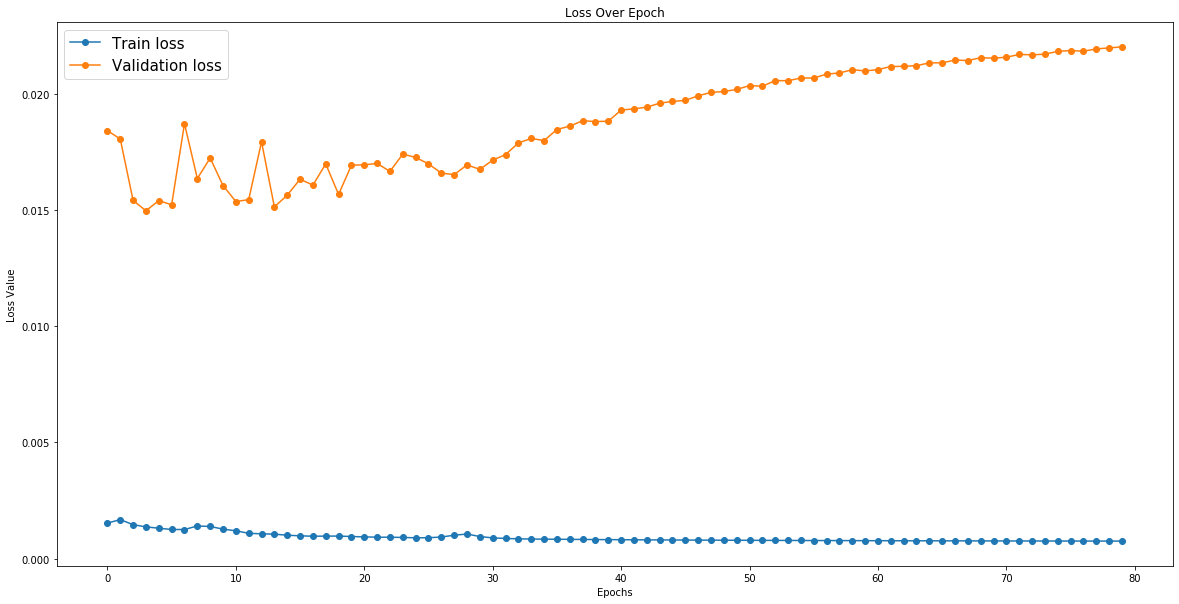

In [28]:
plt.figure(figsize=(20, 10))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 15)
plt.show()

In [ ]:
# the above result are achieved by training with only augmented data (trained twice, once offline that has affine, once without affine)

In [30]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model_0428_0.82.pth'))
unet_model.load_state_dict(state_dict)

# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.
mean_test_score = 0
test_score = []

for batch, data in enumerate(testloader):
    # Data prepared to be given as input to model.
    image = data['image'].to(device, dtype=torch.float)
    mask = data['mask']

    # Predicted output from the input sample.
    mask_prediction = unet_model(image).cpu()
    # Threshold elimination.
    mask_prediction = (mask_prediction > 0.5)
    mask_prediction = mask_prediction.numpy()

    mask = np.resize(mask, (155, 240, 240))
    mask_prediction = np.resize(mask_prediction, (155, 240, 240))

    # Calculating the dice score for original and predicted mask.
    mean_test_score += dice_coefficient(mask_prediction, mask)
    test_score.append(dice_coefficient(mask_prediction, mask))

# Calculating the mean score for the whole test dataset.
unet_score = mean_test_score / data_length
# Putting the model back to training mode.
print(f'\nDice Score {unet_score}\n')


Dice Score 0.8240687175747964



In [33]:
import pandas as pd
score = pd.DataFrame(test_score, columns=['baseline'])
score.to_csv('score.csv')

In [34]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'torchio_ol_aug_noAffine_model.pth'))
unet_model.load_state_dict(state_dict)

# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.
mean_test_score = 0
test_score = []

for batch, data in enumerate(testloader):
    # Data prepared to be given as input to model.
    image = data['image'].to(device, dtype=torch.float)
    mask = data['mask']

    # Predicted output from the input sample.
    mask_prediction = unet_model(image).cpu()
    # Threshold elimination.
    mask_prediction = (mask_prediction > 0.5)
    mask_prediction = mask_prediction.numpy()

    mask = np.resize(mask, (155, 240, 240))
    mask_prediction = np.resize(mask_prediction, (155, 240, 240))

    # Calculating the dice score for original and predicted mask.
    mean_test_score += dice_coefficient(mask_prediction, mask)
    test_score.append(dice_coefficient(mask_prediction, mask))

# Calculating the mean score for the whole test dataset.
unet_score = mean_test_score / data_length
# Putting the model back to training mode.
print(f'\nDice Score {unet_score}\n')


Dice Score 0.7722799770250905



In [35]:
score = pd.read_csv('score.csv')
score['torchio_only'] = test_score
score.to_csv('score.csv')

# May 7th
# train with original and ol augmentation without affine. 
# first we'll train with the last t.7722799 model, then maybe try keep loading the baseline .82 model. 

In [ ]:
# update: training with last 0.7722799 model is not working, highest is the first, but then it goes down to 0.6
# we will retrain the baseline with purely online augmentation

In [20]:
# first load the model trained with offline augmented data
# loading the previous best model (from online augmentation)
# for the new online augmentation without affine and different probability

# a new epoch
epochs = 20

unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&torchio_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
# Use when you want to continue training a pre-train model.
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model_0428_0.82.pth'))  # the newest .77 model
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)


# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1
    

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    train_score, validation_score, validation_loss = 0, 0, 0
    
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
            
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        data = ol_aug_noAffine(data)
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
#     for batch, data in enumerate(trainloader_aug):
#         # Keeping track how many iteration is happening.
#         batch_iteration += 1
#         # Loading data to device used.
#         image = data['image'].to(device, dtype=torch.float)
#         mask = data['mask'].to(device, dtype=torch.float)
        
#         #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         # Clearing gradients of optimizer.
#         optimizer.zero_grad()
#         # Calculation predicted output using forward pass.
#         output = unet_model(image)
#         # Calculating the loss value.
#         loss_value = criterion(output, mask)
#         # Computing the gradients.
#         loss_value.backward()
#         # Optimizing the network parameters.
#         optimizer.step()
#         # Updating the running training loss
#         train_epoch_loss += loss_value.item()
#         train_batch_loss += loss_value.item()
        
#         mask_prediction = unet_model(image)
#         mask_prediction = (mask_prediction > 0.5)
#         mask_prediction = mask_prediction.cpu().numpy()
#         mask_prediction = np.resize(mask_prediction, (155, 240, 240))
#         mask = mask.cpu().numpy()
#         # Calculate the dice score for original and predicted image mask.
#         train_score += dice_coefficient(mask_prediction, mask)
    

#         # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
#         if mini_batch:
#             if (batch + 1) % mini_batch == 0:
#                 train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
#                 print(
#                     f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
#                 train_batch_loss = 0
    
    unet_train = train_score / batch_iteration
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'train score: {unet_train:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'ori_torchio_ol_aug_noAffine_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.00163,  train score: 0.38119,  validation Loss: 0.01585,  validation score: 0.68918,  current lr:  0.0001 , Time: 909.05 s	Best model saved at score: 0.68918
Epoch:   2,  train Loss: 0.00149,  train score: 0.43070,  validation Loss: 0.01573,  validation score: 0.66324,  current lr:  0.0001 , Time: 905.56 s
Epoch:   3,  train Loss: 0.00138,  train score: 0.36418,  validation Loss: 0.01579,  validation score: 0.69734,  current lr:  0.0001 , Time: 903.81 s	Best model saved at score: 0.69734
Epoch:   4,  train Loss: 0.00138,  train score: 0.43414,  validation Loss: 0.01669,  validation score: 0.67204,  current lr:  0.0001 , Time: 904.59 s
Epoch:   5,  train Loss: 0.00140,  train score: 0.36563,  validation Loss: 0.01547,  validation score: 0.68595,  current lr:  0.0001 , Time: 902.70 s
Epoch:   6,  train Loss: 0.00130,  train score: 0.43426,  validation Loss: 0.01444,  validation score: 0.71504,  current lr:  0.0001 , Time: 904.01 s	Best

**The result is good with only 20 epochs, the bst model is 12st epoch**

In [24]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'ori_torchio_ol_aug_noAffine_model.pth'))
unet_model.load_state_dict(state_dict)

# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.
mean_test_score = 0
test_score = []

for batch, data in enumerate(testloader):
    # Data prepared to be given as input to model.
    image = data['image'].to(device, dtype=torch.float)
    mask = data['mask']

    # Predicted output from the input sample.
    mask_prediction = unet_model(image).cpu()
    # Threshold elimination.
    mask_prediction = (mask_prediction > 0.5)
    mask_prediction = mask_prediction.numpy()

    mask = np.resize(mask, (155, 240, 240))
    mask_prediction = np.resize(mask_prediction, (155, 240, 240))

    # Calculating the dice score for original and predicted mask.
    mean_test_score += dice_coefficient(mask_prediction, mask)
    test_score.append(dice_coefficient(mask_prediction, mask))

# Calculating the mean score for the whole test dataset.
unet_score = mean_test_score / data_length
# Putting the model back to training mode.
print(f'\nDice Score {unet_score}\n')


Dice Score 0.7974220197205032



In [26]:
import pandas as pd
score = pd.read_csv('score.csv')
score['original_olaug_noaffine'] = test_score
score.to_csv('score.csv')

# May 7 night update: now the result looks promising after 20 epochs, Keep training this model for 80 epochs. 

if it doesnot work, we will try loading the baseline 0.82 and train with 80~100 epochs. But theoretically hope it'll work.

# midnight update: performs below expectation, will train with baseline model. 

the original plan above (May 7 night) has a v.score bouncing around 0.7~0.6

In [21]:
# first load the model trained with offline augmented data
# loading the previous best model (from online augmentation)
# for the new online augmentation without affine and different probability

# a new epoch
epochs = 80

unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&torchio_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
# Use when you want to continue training a pre-train model.
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model_0428_0.82.pth'))  # the newest v.73 model
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)


# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1
    

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    train_score, validation_score, validation_loss = 0, 0, 0
    
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
            
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        data = ol_aug_noAffine(data)
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
#     for batch, data in enumerate(trainloader_aug):
#         # Keeping track how many iteration is happening.
#         batch_iteration += 1
#         # Loading data to device used.
#         image = data['image'].to(device, dtype=torch.float)
#         mask = data['mask'].to(device, dtype=torch.float)
        
#         #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         # Clearing gradients of optimizer.
#         optimizer.zero_grad()
#         # Calculation predicted output using forward pass.
#         output = unet_model(image)
#         # Calculating the loss value.
#         loss_value = criterion(output, mask)
#         # Computing the gradients.
#         loss_value.backward()
#         # Optimizing the network parameters.
#         optimizer.step()
#         # Updating the running training loss
#         train_epoch_loss += loss_value.item()
#         train_batch_loss += loss_value.item()
        
#         mask_prediction = unet_model(image)
#         mask_prediction = (mask_prediction > 0.5)
#         mask_prediction = mask_prediction.cpu().numpy()
#         mask_prediction = np.resize(mask_prediction, (155, 240, 240))
#         mask = mask.cpu().numpy()
#         # Calculate the dice score for original and predicted image mask.
#         train_score += dice_coefficient(mask_prediction, mask)
    

#         # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
#         if mini_batch:
#             if (batch + 1) % mini_batch == 0:
#                 train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
#                 print(
#                     f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
#                 train_batch_loss = 0
    
    unet_train = train_score / batch_iteration
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'train score: {unet_train:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'ori_torchio_ol_aug_noAffine_model_80.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.00165,  train score: 0.40070,  validation Loss: 0.01397,  validation score: 0.70575,  current lr:  0.0001 , Time: 916.89 s	Best model saved at score: 0.70575
Epoch:   2,  train Loss: 0.00150,  train score: 0.36487,  validation Loss: 0.01434,  validation score: 0.72741,  current lr:  0.0001 , Time: 913.25 s	Best model saved at score: 0.72741
Epoch:   3,  train Loss: 0.00140,  train score: 0.43148,  validation Loss: 0.01429,  validation score: 0.71677,  current lr:  0.0001 , Time: 913.53 s
Epoch     4: reducing learning rate of group 0 to 8.5000e-05.
Epoch:   4,  train Loss: 0.00221,  train score: 0.40165,  validation Loss: 0.02646,  validation score: 0.48835,  current lr:  8.5e-05 , Time: 911.10 s
Epoch:   5,  train Loss: 0.00222,  train score: 0.40418,  validation Loss: 0.01574,  validation score: 0.66165,  current lr:  8.5e-05 , Time: 910.93 s
Epoch:   6,  train Loss: 0.00132,  train score: 0.36466,  validation Loss: 0.01514,  valid

In [28]:
# first load the model trained with offline augmented data
# loading the previous best model (from online augmentation)
# for the new online augmentation without affine and different probability

# a new epoch
epochs = 30

unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&torchio_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
# Use when you want to continue training a pre-train model.
state_dict = torch.load(os.path.join(model_save_path, 'ori_torchio_ol_aug_noAffine_model_80.pth'))  # the newest v.73 model
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)


# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1
    

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    train_score, validation_score, validation_loss = 0, 0, 0
    
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
            
    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        data = ol_aug_noAffine(data)
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        
        #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        mask_prediction = unet_model(image)
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        mask = mask.cpu().numpy()
        # Calculate the dice score for original and predicted image mask.
        train_score += dice_coefficient(mask_prediction, mask)
    

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0
    
#     for batch, data in enumerate(trainloader_aug):
#         # Keeping track how many iteration is happening.
#         batch_iteration += 1
#         # Loading data to device used.
#         image = data['image'].to(device, dtype=torch.float)
#         mask = data['mask'].to(device, dtype=torch.float)
        
#         #image = image.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         #mask = mask.permute(0, 3, 1, 2).view([BATCH_SIZE,155,240,240])
#         # Clearing gradients of optimizer.
#         optimizer.zero_grad()
#         # Calculation predicted output using forward pass.
#         output = unet_model(image)
#         # Calculating the loss value.
#         loss_value = criterion(output, mask)
#         # Computing the gradients.
#         loss_value.backward()
#         # Optimizing the network parameters.
#         optimizer.step()
#         # Updating the running training loss
#         train_epoch_loss += loss_value.item()
#         train_batch_loss += loss_value.item()
        
#         mask_prediction = unet_model(image)
#         mask_prediction = (mask_prediction > 0.5)
#         mask_prediction = mask_prediction.cpu().numpy()
#         mask_prediction = np.resize(mask_prediction, (155, 240, 240))
#         mask = mask.cpu().numpy()
#         # Calculate the dice score for original and predicted image mask.
#         train_score += dice_coefficient(mask_prediction, mask)
    

#         # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
#         if mini_batch:
#             if (batch + 1) % mini_batch == 0:
#                 train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
#                 print(
#                     f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
#                 train_batch_loss = 0
    
    unet_train = train_score / batch_iteration
    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'train score: {unet_train:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'ori_torchio_ol_aug_noAffine_model_80.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.00120,  train score: 0.37098,  validation Loss: 0.01915,  validation score: 0.64900,  current lr:  0.0001 , Time: 889.14 s	Best model saved at score: 0.64900
Epoch:   2,  train Loss: 0.00116,  train score: 0.44199,  validation Loss: 0.01900,  validation score: 0.65674,  current lr:  0.0001 , Time: 874.37 s	Best model saved at score: 0.65674
Epoch:   3,  train Loss: 0.00120,  train score: 0.43934,  validation Loss: 0.01552,  validation score: 0.68771,  current lr:  0.0001 , Time: 874.91 s	Best model saved at score: 0.68771
Epoch:   4,  train Loss: 0.00120,  train score: 0.44228,  validation Loss: 0.01714,  validation score: 0.67434,  current lr:  0.0001 , Time: 874.96 s
Epoch:   5,  train Loss: 0.00120,  train score: 0.37356,  validation Loss: 0.02348,  validation score: 0.57818,  current lr:  0.0001 , Time: 874.30 s
Epoch     6: reducing learning rate of group 0 to 8.5000e-05.
Epoch:   6,  train Loss: 0.00385,  train score: 0.37552, 

In [21]:
def result(image, mask, output, title, transparency = 0.38, save_path = None):
    '''
    Plots a 2x3 plot with comparisons of output and original image.
    Works best with Jupyter Notebook/Lab.
    Parameters:
        image(numpy.ndarray): Array containing the original image of MRI scan.
        mask(numpy.ndarray): Array containing the original mask of tumor.
        output(numpy.ndarray): Model predicted mask from input image.
        title(str): Title of the plot to be used.
        transparency(float): Transparency level of mask on images.
                             Default: 0.38
        save_path(str): Saves the plot to the location specified.
                        Does nothing if None. 
                        Default: None
    Return:
        None
    '''

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(
        10, 8), gridspec_kw={'wspace': 0.025, 'hspace': 0.010})
    fig.suptitle(title, x=0.5, y=0.92, fontsize=20)

    axs[0][0].set_title("Original Mask", fontdict={'fontsize': 16})
    axs[0][0].imshow(mask, cmap='gray')
    axs[0][0].set_axis_off()

    axs[0][1].set_title("Predicted Mask", fontdict={'fontsize': 16})
    axs[0][1].imshow(output, cmap='gray')
    axs[0][1].set_axis_off()

    mask_diff = np.abs(np.subtract(mask, output))
    axs[0][2].set_title("Mask Difference", fontdict={'fontsize': 16})
    axs[0][2].imshow(mask_diff, cmap='gray')
    axs[0][2].set_axis_off()

    seg_output = mask*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][0].set_title("Original Segmentation", fontdict={'fontsize': 16})
    axs[1][0].imshow(seg_image, cmap='gray')
    axs[1][0].set_axis_off()
    
    seg_output = output*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][1].set_title("Predicted Segmentation", fontdict={'fontsize': 16})
    axs[1][1].imshow(seg_image, cmap='gray')
    axs[1][1].set_axis_off()

    axs[1][2].set_title("Original Input Image", fontdict={'fontsize': 16})
    axs[1][2].imshow(image, cmap='gray')
    axs[1][2].set_axis_off()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi = 90, bbox_inches = 'tight')

    plt.show()

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

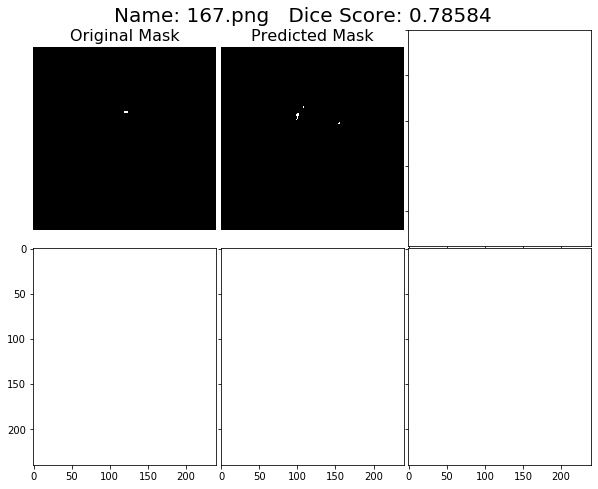

In [22]:
for example_index in range(10):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]
    threshold = 0.5

    unet_model.eval()
    image = sample['image'].numpy()
    mask = sample['mask'].numpy()

    image_tensor = torch.Tensor(image)
    image_tensor = image_tensor.view((-1, 155, 240, 240)).to(device)
    output = unet_model(image_tensor).detach().cpu()
    output = (output > threshold)
    output = output.numpy()
    d_score = dice_coefficient(output, mask)

    image = np.resize(image, (155, 240, 240))
    image = image[70,:,:]
    mask = np.resize(mask, (155, 240, 240))
    mask = mask[70,:,:]
    output = np.resize(output, (155, 240, 240))
    output = output[70,:,:]
    # score(float): Sørensen–Dice Coefficient for mask and output. Calculates how similar are the two images.
    #d_score = dice_coefficient(output, mask)

    title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
    # save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
    result(image, mask, output, title, save_path = None)